## Applications of ECOSTRESS: Drought and Wildfire Risk Assessment
### 📍Rocky Mountain National Park, Colorado, USA

Wildfire impacts to communities are on the rise across much of the world and especially in western North America. Increasing extreme fire behavior and societal impacts are associated with a warmer and drier climate (REF), lack of fire and a culture of fire suppression in fire-prone regions (REF), and rapid development in flammable landscapes (REF). 

The Wildland Urban Interface (WUI), where homes and building intermix with wildland fuels, is the fastest growing land use type in the US with XXXM more people living in the WUI since XXXX leading to increasing wildfire-related impacts (REF). While many regions of the western US are at high risk, the Colorado Front Range is particularly vulnerable/susceptible given the rapidly growing population and impacts from changing climatic patterns leading to more extreme fire behavior (REF). The 2020 fire season was record-setting in terms of area burned globally (REF). In CO it produced three of the state's top five largest wildfires. In particular, the Cameron Peak and East Troublesome fires both resulted in extreme fire behavior and hundreds of destroyed structures on the Front Range.

Satellite earth observation (EO) has contributed to major advances in understanding fire risk and impacts in recent decades. Characterization of vegetative fuel using multispectral and radar imagery has changed the way we model fire behavior. Active mapping of wildfire hotspots and daily growth has improved firefighter safety and led to a better understanding of the mechanisims which drive fire growth. Future advances in tracking fuel conditions in near-real-time will improve our ability to understand and map fire risk for communities and fire management personnel.

The ECOSTRESS mission provides thermal remote sensing and derivatives such as evapotranspiration. These metrics provide crucial information on the conditions of vegetation fuels on the landscape. Previous research has shown relationships between the intensity and severity of a wildfire and the water stress in plants measured in the months before wildfire: https://ecostress.jpl.nasa.gov/news/111cnasa-data-on-plant-2018sweating-could-help-predict-wildfire-severity

Citations:

1.
2.

Data Sources:
- Colorado Fire Protection Districts:
- Rocky Mountain National Park boundary:

## Search and download ECOSTRESS Land Surface Temp. (LST) and Evaporative Stress Index (ESI)

In this notebook, we will use the 'earthaccess' Python package to search and download ECOSTRESS data products which overlap the Park. For more background and detailed examples of using 'earthaccess', refer to the introductory notebook from earlier (link to intro notebook). Using this package, we can search for ECOSTRESS granules using our region of interest and identify ones which meet certain criteria for analysis.

### Step 1. Setup the Notebook

First, we need to import our Python packages and define some environment variable like coordinate reference systems and file paths. 

In [1]:
"""
Load the necessary packages and set environment variables
"""

# Import packages
import os, shutil, time
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import math

from osgeo import gdal
from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

# Projection information
geog = 'EPSG:4326'  # Geographic projection
prj = 'EPSG:5070'  # Projected coordinate system- WGS 84 NAD83 UTM Zone 13N

# File path information
datadir = '/data-store/iplant/home/shared/esiil/HYR_SENSE/'

# File path information
print("Success")

Success


#### Define Custom Functions

These helper functions will be used throughout the notebook. For each function, there is a description of what purpose it serves and where it is used in the notebook. Feel free to read through each function to get an idea of what it does, but we will not cover these in great detail. Ask a facilitator if you have any questions!

In [2]:
def get_shapely_object(result:earthaccess.results.DataGranule):
    """
    Retrieve geospatial information from ECOSTRESS granule footprints.
    This function allows us to retrieve the geographic coverage for each granule and plot it on a map.
    
    :param 'result:earthaccess.results.DataGranule': a single data granule from earthaccess data search
    """
    
    # Get Geometry Keys
    geo = result['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']
    keys = geo.keys()

    if 'BoundingRectangles' in keys:
        bounding_rectangle = geo['BoundingRectangles'][0]
        # Create bbox tuple
        bbox_coords = (bounding_rectangle['WestBoundingCoordinate'],bounding_rectangle['SouthBoundingCoordinate'],
                       bounding_rectangle['EastBoundingCoordinate'],bounding_rectangle['NorthBoundingCoordinate'])
        # Create shapely geometry from bbox
        shape = geometry.box(*bbox_coords, ccw=True)
    elif 'GPolygons' in keys:
        points = geo['GPolygons'][0]['Boundary']['Points']
        # Create shapely geometry from polygons
        shape = geometry.Polygon([[p['Longitude'],p['Latitude']] for p in points])
    else:
         raise ValueError('Provided result does not contain bounding boxes/polygons or is incompatible.')
    return(shape)


def get_png(result:earthaccess.results.DataGranule):
    """
    Retrieve the browse image from the search results
    This browse image can be used to display the granule quickly and effectively before downloading

    :param 'result:earthaccess.results.DataGranule': a single data granule from earthaccess data search
    """
    https_links = [link for link in result.dataviz_links() if 'https' in link]
    if len(https_links) == 1:
        browse = https_links[0]
    elif len(https_links) == 0:
        browse = 'no browse image'
        warnings.warn(f"There is no browse imagery for {result['umm']['GranuleUR']}.")
    else:
        browse = [png for png in https_links if '.png' in png][0]
    return(browse)


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation
    Leaflet interactive maps require a specific format for coordinates, this function sets that up for a given bounding box.

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))


def extract_granule_id(link):
    return os.path.basename(link)[:-3]
    
print("Functions are ready to use!")

Functions are ready to use!


### Step 2. Data Preparation

#### Accessing data from the CyVerse Data Store

The CyVerse "data store" contains some geospatial and tabular data for the workshop. These data can be accessed directly using file paths. However, this sometimes can cause delays. To avoid these issues, we can copy the data for this notebook into a local directory.

In [3]:
"""
Copy the data-store to 'local' directory
This enables quick access to data files
"""

# Identify the location of the HYR-SENSE "data store"
data_store_path = '/data-store/iplant/home/shared/esiil/HYR_SENSE/data/Drought-FireRisk'
# Set a destination path (this is a 'local' and temporary path)
dest = '/home/jovyan/HYR-SENSE/data/Drought-FireRisk/' # in the GitHub repo we cloned
if not os.path.exists(dest):
    os.mkdir(dest) # create the directory for the copied data, if needed
    
# Using 'shutil' package, copy all the files over
shutil.copytree(data_store_path, dest, dirs_exist_ok=True)

'/home/jovyan/HYR-SENSE/data/Drought-FireRisk/'

#### Importing project data

Now that we have a local copy of our project data, we can read in some of the data files like our region of interest (ROI). For this notebook, we will load two spatial datasets:

- Rocky Mountain National Park (RMNP)
- Colorado Fire Protection Districts (FPDs)

Fire protection districts (FPDs) are ...

To begin, let's create a map of our ROI and the intersecting FPDs.

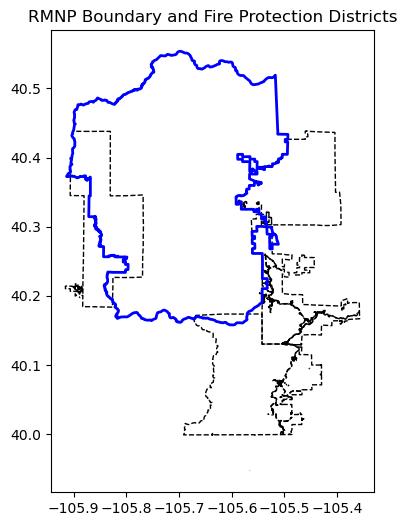

In [39]:
# Load the RMNP boundary as a GeoJSON using the Python package GeoPandas
rmnp = gpd.read_file(os.path.join(dest, 'NPS_ROMO_Boundary.geojson'))
rmnp = rmnp.to_crs(prj) # projected CRS

# Load the Colorado Fire Protection Districts
# Intersect with the RMNP boundary
fpd = gpd.read_file(os.path.join(dest, 'CO_Fire_Protection_Districts.geojson'))
fpd = fpd.to_crs(prj) # make sure the projections match
fpd_rmnp = fpd[fpd.intersects(rmnp.unary_union)] # Perform the spatial intersection

# Create a map of RMNP and adjacent FPDs
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# Plot the intersecting Fire Protection Districts
# (convert to geographic coordinates so axis labels are in lat/long)
fpd_rmnp.to_crs(geog).plot(ax=ax, color='none', edgecolor='black', linewidth=1, linestyle='--', label='Intersecting Districts')
# Plot the RMNP boundary 
rmnp.to_crs(geog).plot(ax=ax, color='none', edgecolor='blue', linewidth=2, label='RMNP Boundary')
# Add legend and title
plt.title('RMNP Boundary and Fire Protection Districts')
plt.show()

### Step 3. Search for ECOSTRESS Data 
 - Land Surface Temperature and Emissivity Daily L2 Global 70 m
 - Evaporative Stress Index (ESI) PT-JPL Daily L4 Gloabl 70 m 

Now that we have our ROI loaded, we can use the "earthaccess" Python package to find ECOSTRESS data products. In particular, we will search for the Land Surface Temperature and Emissivity Daily Gridded L2 70-m product (ECO_L2G_LSTE) and the Evaporative Stress Index Daily L4 70 m product (ECO4ESIPTJPL). With earthaccess, we can search for and print all of the available data sets. Using this capability, we can also search for a specific data product by its "short name". To start, let's get a list of all the ECOSTRESS products available.

Read more about the data products:\
ECOSTRESS LSTE: https://lpdaac.usgs.gov/products/eco2lstev001/ \
ECOSTRESS ESI: https://lpdaac.usgs.gov/products/eco4esiptjplv001/


In [5]:
# Log in to your NASA Earthdata
# You only have to do this once in your session (persist=True saves the credentials)
auth = earthaccess.login(persist=True)

#### Search for available ECOSTRESS products

To begin, we can identify a list of available products. The "ShortName" attribute may not give enough description, so some initial work to identify which data products you are interested in is helpful. In our case we are looking for LST and ESI; "ECO_L2G_LSTE" and "ECO4ESIPTJPL", respectively.

In [6]:
## Query the collections for ECOSTRESS
Query = earthaccess.collection_query().keyword('ECOSTRESS')
print(f'Collections found: {Query.hits()}')

# Return search results as a list
collections = Query.fields(['ShortName']).get(Query.hits())

# Retrieve Collection short-names
print("All available data products: ")
[product['short-name'] for product in [collection.summary() for collection in collections]]

Collections found: 37
All available data products: 


['ECO2LSTE',
 'ECO4ESIPTJPL',
 'ECO4WUE',
 'ECO3ETPTJPL',
 'ECO2CLD',
 'ECO1BMAPRAD',
 'ECO1BRAD',
 'ECO3ETALEXI',
 'ECO4ESIALEXI',
 'ECO1BGEO',
 'ECO4ESIALEXIU',
 'ECO_L4G_ESI',
 'ECO_L4G_WUE',
 'ECO_L4T_ESI',
 'ECO_L4T_WUE',
 'ECO3ANCQA',
 'ECO3ETALEXIU',
 'ECO_L3G_JET',
 'ECO_L3G_MET',
 'ECO_L3G_SEB',
 'ECO_L3G_SM',
 'ECO_L3T_JET',
 'ECO_L3T_MET',
 'ECO_L3T_SEB',
 'ECO_L3T_SM',
 'ECO_L2G_CLOUD',
 'ECO_L2G_LSTE',
 'ECO_L2T_LSTE',
 'ECO_L2T_STARS',
 'ECO_L2_CLOUD',
 'ECO_L2_LSTE',
 'ECO1BATT',
 'ECO_L1B_ATT',
 'ECO_L1B_GEO',
 'ECO_L1B_RAD',
 'ECO_L1CG_RAD',
 'ECO_L1CT_RAD']

#### Define a search request using 'earthaccess'

We are ready to submit a search request for our ECOSTRESS data over RMNP. For this exercise, we will look for data within three seasonal time periods; spring (May-June), summer (July-August) and fall (September). This will facilitate an investogation into how surface temperatures and vegetation drought stress change over a fire season. 

Add more description of the below code chunk ...

In [45]:
# 1. Define some search parameters 
# Version 001: ['ECO2LSTE', 'ECO4ESIPTJPL']
# Version 002: ['ECO_L2T_LSTE', 'ECO_L4T_ESI']
short_names =  ['ECO_L2T_LSTE', 'ECO_L3T_JET'] 
date_range = ('2023-05-01','2024-06-05')

# 2. Retrieve the coordinate pairs for the region of interest
geom = rmnp.geometry.buffer(1000).to_crs(geog) # convert back to geographic coordinates
geom = geom.unary_union.envelope # dissolve into a single shape and get the envelope
coords = list(geom.exterior.coords) # retrieve the coordinate pairs

# 3. Loop through each short name
# Looping here helps us see how many tiles exist for each product
results = {} # empty dictionary to store the search results for each product
for short_name in short_names:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Data product: {short_name}")
    i=0 # counter
    
    # 4a. Search for ECOSTRESS products matching our short names
    result = earthaccess.search_data(
        short_name=short_name,
        polygon=coords,
        temporal=date_range,
        count=500, 
    )        
    
    # 4b. Save the results as a data frame, append to dictionary
    df = pd.json_normalize(result)
    df['shortname'] = short_name
        
    # 4c. Create shapely polygons for result
    geometries = [get_shapely_object(result[index]) for index in df.index.to_list()]
    # Convert to GeoDataframe
    results_gdf = gpd.GeoDataFrame(df, geometry=geometries, crs="EPSG:4326")
    
    # 4d. Add browse imagery links (we will use this later)
    results_gdf['browse'] = [get_png(granule) for granule in result]
    
    # 4e. Retrieve the data links (used later for downloading)
    data_links = pd.DataFrame([granule.data_links()[0] for granule in result], columns=['data_link']) 
    results_gdf = pd.concat([results_gdf, data_links], axis=1)  # join the data links back to our search results

     # 4f. Filter for daytime observations
    results_gdf = results_gdf[results_gdf['umm.DataGranule.DayNightFlag'].str.contains('Day')]
    print(f'Daytime observations: {len(results_gdf)}')
    
    i=i+1

    # Add to the dictionary
    results[short_name] = results_gdf

~~~~~~~~~~~~~~~~~~~~~~~~~~~
Data product: ECO_L2T_LSTE
Granules found: 386
Daytime observations: 197
~~~~~~~~~~~~~~~~~~~~~~~~~~~
Data product: ECO_L3T_JET
Granules found: 31
Daytime observations: 18


#### Examine the metadata from the search results  
It looks like we have some options for data products during this spatial and temporal window. However, to identify data granules which will be useful for analysis, we need to dig into the metadata a bit more. Thankfully, the earthaccess enables us to work with the metadata from our search results as a data frame. 

In [51]:
# Let's take a look at the columns available in the metadata
for key, value in results.items():
    print(key)
    print(f'{len(value)} granules total.')
    print(value.columns)
    print(value['geometry'].head())

ECO_L2T_LSTE
197 granules total.
Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.collection-concept-id', 'meta.provider-id',
       'meta.format', 'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime',
       'umm.OrbitCalculatedSpatialDomains', 'umm.GranuleUR',
       'umm.AdditionalAttributes', 'umm.MeasuredParameters',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.BoundingRectangles',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEVersion',
       'umm.RelatedUrls', 'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.Identifiers', 'umm.DataGranule.ProductionDateTime',
       'umm.DataGranule.ArchiveAndDistributionInformation', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecif

#### Keep only granules which fully contain our study region

Using the footprint spatial information, we can remove granules from our list which do not fully contain our study region.

In [53]:
# Function to check if a bounding box fully contains the romo region
def bbox_contains(bbox_geom, roi_geom):
    return bbox_geom.contains(roi_geom.unary_union)

geom = rmnp.geometry.buffer(1000).to_crs(geog)

# Filter results based on spatial containment
results_rmnp = {}
for key, gdf in results.items():
    print(f'{key}: {len(value)} granules total.')
    # Check if the granule completely contains the bounding box of our study region
    filtered = gdf[gdf['geometry'].apply(lambda x: bbox_contains(x, geom))]
    print(f'Removed {len(gdf)-len(filtered)} granules with partial overlap. \n ({len(filtered)} total)')

    # Rename some of the columns for easier access
    filtered = filtered.copy()
    filtered.rename(
        columns = {'meta.concept-id':'concept_id',
                   'meta.native-id':'granule',
                   'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
                   'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
                   'umm.DataGranule.DayNightFlag':'day_night',
                   'umm.CloudCover':'cloud_cover',
                  }, inplace=True)
    filtered['datetime_obj'] = pd.to_datetime(filtered['start_datetime']) 

    # Append the filtered results back to the new dictionary
    results_rmnp[key] = filtered

# Examine the data frame for one product
results_rmnp[short_names[0]].head()

ECO_L2T_LSTE: 18 granules total.
Removed 95 granules with partial overlap. 
 (102 total)
ECO_L3T_JET: 18 granules total.
Removed 9 granules with partial overlap. 
 (9 total)


,size,meta.concept-type,concept_id,meta.revision-id,granule,meta.collection-concept-id,meta.provider-id,meta.format,meta.revision-date,start_datetime,...,umm.DataGranule.ArchiveAndDistributionInformation,umm.Platforms,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version,shortname,geometry,browse,data_link,datetime_obj
0,17.93260,granule,G2712348518-LPCLOUD,1,ECOv002_L2T_LSTE_27352_012_13TDE_20230503T1420...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2023-06-16T04:25:39.932Z,2023-05-03T14:20:12.600Z,...,"[{'Name': 'Not provided', 'Size': 17.9326, 'Si...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,ECO_L2T_LSTE,"POLYGON ((-104.88503 39.65611, -104.88503 40.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2023-05-03 14:20:12.600000+00:00
12,1.99485,granule,G2715787085-LPCLOUD,1,ECOv002_L2T_LSTE_27714_008_13TDE_20230526T2207...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2023-06-20T01:52:55.351Z,2023-05-26T22:07:49.730Z,...,"[{'Name': 'Not provided', 'Size': 1.99485, 'Si...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,ECO_L2T_LSTE,"POLYGON ((-104.88503 39.65611, -104.88503 40.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2023-05-26 22:07:49.730000+00:00
17,1.65000,granule,G2710722699-LPCLOUD,4,ECOv002_L2T_LSTE_27989_008_13TDE_20230613T1532...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2023-06-23T09:05:44.469Z,2023-06-13T15:32:50.257Z,...,"[{'Name': 'Not provided', 'Size': 1.65, 'SizeU...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,ECO_L2T_LSTE,"POLYGON ((-104.88503 39.65611, -104.88503 40.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2023-06-13 15:32:50.257000+00:00
19,1.18000,granule,G2716597877-LPCLOUD,2,ECOv002_L2T_LSTE_27993_008_13TDE_20230613T2202...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2023-06-25T07:14:05.042Z,2023-06-13T22:02:21.300Z,...,"[{'Name': 'Not provided', 'Size': 1.18, 'SizeU...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,ECO_L2T_LSTE,"POLYGON ((-104.88503 39.65611, -104.88503 40.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2023-06-13 22:02:21.300000+00:00
20,2.95000,granule,G2716208978-LPCLOUD,1,ECOv002_L2T_LSTE_28004_004_13TDE_20230614T1443...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2023-06-20T14:06:07.230Z,2023-06-14T14:43:43.898Z,...,"[{'Name': 'Not provided', 'Size': 2.95, 'SizeU...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,ECO_L2T_LSTE,"POLYGON ((-104.88503 39.65611, -104.88503 40.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2023-06-14 14:43:43.898000+00:00


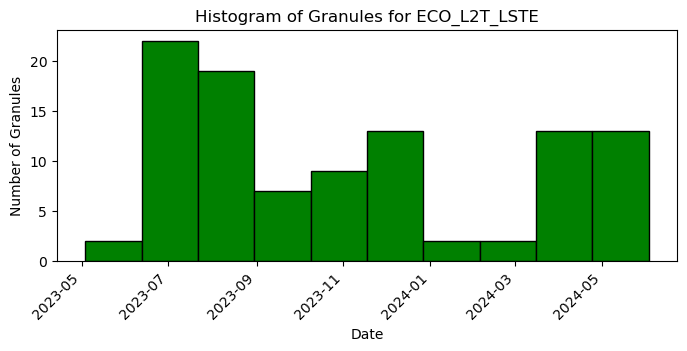

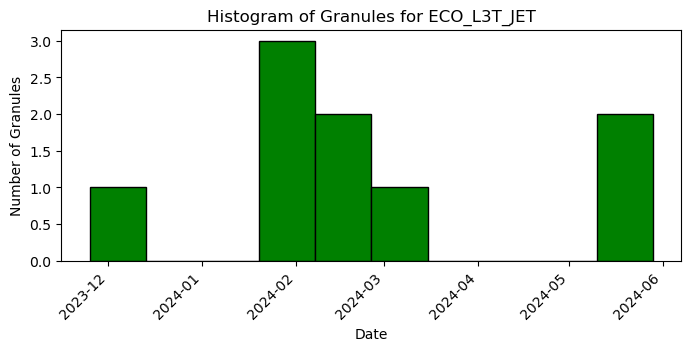

In [56]:
# Plot the histogram of granules for each time period
for key, gdf in results_rmnp.items():
    plt.figure(figsize=(8, 3))
    plt.hist(gdf['datetime_obj'], bins=10, color='green', edgecolor='black', linewidth=1)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Histogram of Granules for {key}')
    plt.xlabel('Date')
    plt.ylabel('Number of Granules')
    plt.show()

#### Identify common acquisition dates between both products

We want to relate LSTE to ESI to try and understand drought-induced fire risk in our study area. So, we need to make sure we can identify granules with the same acquisition date between the two products.


NOTES: use a data frame join here instead of set match

In [33]:
# Identify matching dates between the two products
common_dates = set(results_rmnp[short_names[0]]['start_datetime']).intersection(
    set(results_rmnp[short_names[1]]['start_datetime']))
print(common_dates)

# merge = pd.merge(df1,df2

# Keep matching dates
for key, gdf in results_rmnp.items():
    filtered = gdf[gdf['start_datetime'].isin(common_dates)]
    results_rmnp[key] = filtered
    print(f'{len(filtered)} matching granules.')

{'2020-06-04T20:09:42.350Z', '2020-08-13T16:38:03.140Z', '2020-06-24T12:15:34.970Z', '2020-08-25T18:27:19.970Z', '2020-06-08T18:34:17.510Z', '2020-10-07T18:54:13.040Z', '2020-05-24T00:53:09.720Z', '2020-05-25T00:04:57.700Z', '2020-06-03T20:56:36.420Z', '2020-08-17T15:04:26.970Z', '2020-06-20T20:20:57.750Z', '2020-08-26T17:39:33.890Z', '2020-07-10T12:28:18.980Z', '2020-08-10T00:41:38.800Z', '2020-07-25T00:27:56.950Z', '2020-10-15T15:46:08.000Z', '2020-10-08T18:07:08.320Z', '2020-08-05T19:45:03.920Z', '2020-10-27T17:33:37.640Z', '2020-08-17T21:34:34.640Z', '2020-10-12T23:02:30.310Z', '2020-06-23T13:03:17.490Z', '2020-06-16T15:24:57.540Z', '2020-08-21T13:30:50.930Z', '2020-07-25T00:27:04.980Z', '2020-08-13T16:38:55.110Z', '2020-07-07T13:14:38.900Z', '2020-06-08T18:35:09.480Z', '2020-10-20T19:54:14.650Z', '2020-06-09T01:04:49.890Z', '2020-09-29T21:58:52.300Z', '2020-10-03T20:27:49.580Z', '2020-10-16T14:58:53.860Z', '2020-05-24T00:52:17.750Z', '2020-07-09T13:15:57.930Z', '2020-09-29T21:59:4

#### Visualize the search results

Using the granule footprints, we can make an interactive map showing the granules. We can also create a static map with the granule browse images to help identify quality data.

In [34]:
# Create interactive map with Folium

fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Let's add only the LSTE granules
gdf = results_rmnp[short_names[0]]

# Plot Region of Interest
rmnp.explore(
    popup=False,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="Region of Interest",
    m=map1
)

# Plot the granule footprints
gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="ECOSTRESS",
    m=map1,
    legend=False
)
    
map1.fit_bounds(bounds=convert_bounds(results_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

With so many overlapping granules, the interactive map is not so useful in this context. Let's see if we can identify granules with quality data using the browse images. It may also be helpful to examine the "browse images" which provide a snapshot of the data coverage and can help us identify possible granules for analysis. In the code block below, we use the ECOSTRESS LSTE product browse images to identify granules which may have adequate data for analysis.

Could not load image at https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Browse.001/2020.05.10/ECOSTRESS_L2_LSTE_10430_008_20200508T134001_0601_01.1.jpg: <urlopen error [Errno 101] Network is unreachable>
Could not load image at https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Browse.001/2020.05.10/ECOSTRESS_L2_LSTE_10445_004_20200509T125206_0601_01.1.jpg: <urlopen error [Errno 101] Network is unreachable>
Could not load image at https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Browse.001/2020.05.26/ECOSTRESS_L2_LSTE_10670_004_20200524T005217_0601_01.1.jpg: <urlopen error [Errno 101] Network is unreachable>
Could not load image at https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Browse.001/2020.05.26/ECOSTRESS_L2_LSTE_10670_005_20200524T005309_0601_01.1.jpg: <urlopen error [Errno 101] Network is unreachable>
Could not load image at https://e4ftl01.cr.usgs.gov//WORKING/BRWS/Browse.001/2020.05.27/ECOSTRESS_L2_LSTE_10685_004_20200525T000457_0601_01.1.jpg: <urlopen error [Errno 101] Network is unreachable>
Could not 

/tmp/ipykernel_6300/2213622884.py:30: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


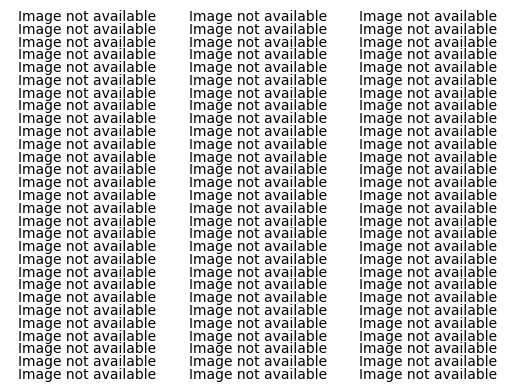

In [35]:
# Look at the browse images to check for quality granules
# Let's do this just for LSTE as we hope the quality days will be the same for both products

short_name = short_names[0] # this is our LST short name identified earlier
gdf = results_rmnp[short_names[0]] # this is the search result dictionary for LST

browse_urls = gdf['browse'].tolist()

cols = 3
rows = math.ceil(len(gdf) / cols)
fig, ax = plt.subplots(rows, cols)
ax = ax.flatten()

for _n, (index, row) in enumerate(gdf.iterrows()):
    try:
        img = io.imread(row['browse'])
        ax[_n].imshow(img)
        ax[_n].set_title(f"{row['start_datetime']}")
        ax[_n].axis('off')
    except Exception as e:
        print(f"Could not load image at {row['browse']}: {e}")
        ax[_n].axis('off')
        ax[_n].text(0.5, 0.5, 'Image not available', ha='center', va='center')

# Turn off any remaining empty subplots
for i in range(_n + 1, len(ax)):
    ax[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show()

#### Download or stream granules

Now we have a list of data links for each season. We can download these data to a local directory

NOTE : set the gdal retries

In [ ]:
## Get Https Session using Earthdata Login Info
fs = earthaccess.get_requests_https_session()

# Define the output directory
dest = '/home/jovyan/HYR-SENSE/data/Drought-FireRisk/' 

t0 = time.time() # begin time

# This list of quality dates was identified by examining the browse images and selecting dates with decent coverage
quality_dates = [
    '2022-06-11T17:06:56.300Z','2022-06-12T16:17:53.670Z', '2022-06-12T16:18:45.640Z', '2022-06-12T22:48.04.640Z',
    '2022-07-31T21:01:33.300Z','2022-08-05T18:34:40.050Z','2022-08-07T18:34:06.890Z','2022-08-08T17:46:18.490Z',
    '2022-10-08T17:27:38.780Z'
]

# Loop through earch search result data frame, retrieve the data links, and download the files
for short_name, gdf in results_rmnp.items():
    gdf = gdf[gdf['start_datetime'].isin(quality_dates)]
    print(f'Downloading {short_name}: {len(gdf)} granules')

    # Grab the download URLs
    data_links = [data_link for data_link in gdf['data_link']]

    # Download the data granules    
    for url in data_links:
        print(url)
        granule_id = os.path.basename(url)
        print(f"Granule ID: {granule_id}")

        out_path = os.path.join(dest,f'{short_name}')
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        fp = os.path.join(out_path,f'{granule_id}')
    
        # Download the Granule Asset if it doesn't exist
        if not os.path.isfile(fp):
            with fs.get(url,stream=True) as src:
                with open(fp,'wb') as dst:
                    for chunk in src.iter_content(chunk_size=64*1024*1024):
                        dst.write(chunk)
        else:
            print("*** Already downloaded ***")
            print(" ")
    
        print('Time to complete granule:', time.time() - t0)

print('Total time:', time.time() - t0)